In [4]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


In [5]:

# 1️⃣ Transformaciones: redimensionar, normalizar, convertir a tensor
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ajusta tamaño al que usarás en la red
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])
])

# 2️⃣ Cargar datasets
train_data = datasets.ImageFolder(
    root=r"C:\Users\AulaDigital\Documents\GitHub\Caso1.-Detecci-n-de-melanomas\data\train",
    transform=transform
)
test_data = datasets.ImageFolder(
    root=r"C:\Users\AulaDigital\Documents\GitHub\Caso1.-Detecci-n-de-melanomas\data\test",
    transform=transform
)


# 3️⃣ DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# 4️⃣ Verificar clases
print("Clases:", train_data.classes)


Clases: ['Benign', 'Malignant']


In [6]:
import torch.nn as nn
import torchvision.models as models


In [7]:

# Cargar ResNet18 preentrenada
model = models.resnet18(pretrained=True)

# Cambiar la capa final para 2 clases: Benign / Malignant
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)


c:\Users\AulaDigital\Documents\GitHub\Caso1.-Detecci-n-de-melanomas\env11\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\AulaDigital\Documents\GitHub\Caso1.-Detecci-n-de-melanomas\env11\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()  # para clasificación de 2 clases
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [9]:
device = torch.device("cpu")  # como vamos a usar CPU
model = model.to(device)

epochs = 5  # empieza con pocas épocas para probar

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")


Epoch 1/5, Loss: 0.2693
Epoch 2/5, Loss: 0.1646
Epoch 3/5, Loss: 0.0974
Epoch 4/5, Loss: 0.0615
Epoch 5/5, Loss: 0.0522


In [11]:
torch.save(model.state_dict(), "resnet18_melanoma.pth")


In [10]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"Accuracy en test: {correct/total:.4f}")


Accuracy en test: 0.9375


In [3]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

all_preds, all_labels = [], []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Accuracy
correct = sum(p==l for p,l in zip(all_preds, all_labels))
total = len(all_labels)
print(f"Accuracy en test: {correct/total:.4f}")


NameError: name 'model' is not defined

Matriz de confusión:
 [[946  54]
 [ 48 952]]


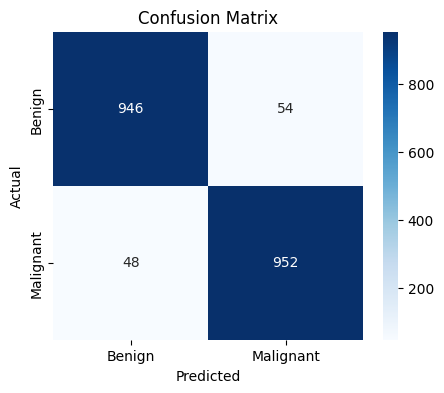

In [17]:
cm = confusion_matrix(all_labels, all_preds)
print("Matriz de confusión:\n", cm)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_data.classes,
            yticklabels=train_data.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


Matriz de confusión:
 [[946  54]
 [ 48 952]]


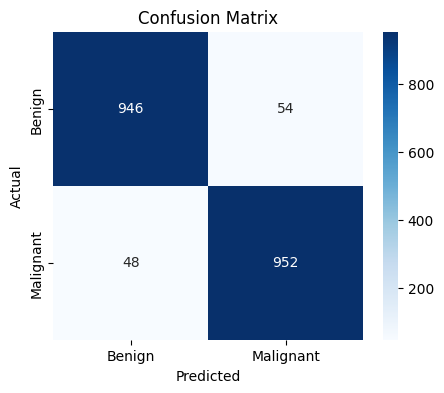

              precision    recall  f1-score   support

      Benign       0.95      0.95      0.95      1000
   Malignant       0.95      0.95      0.95      1000

    accuracy                           0.95      2000
   macro avg       0.95      0.95      0.95      2000
weighted avg       0.95      0.95      0.95      2000



In [19]:
cm = confusion_matrix(all_labels, all_preds)
print("Matriz de confusión:\n", cm)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_data.classes,
            yticklabels=train_data.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Reporte de métricas detallado
print(classification_report(all_labels, all_preds, target_names=train_data.classes))


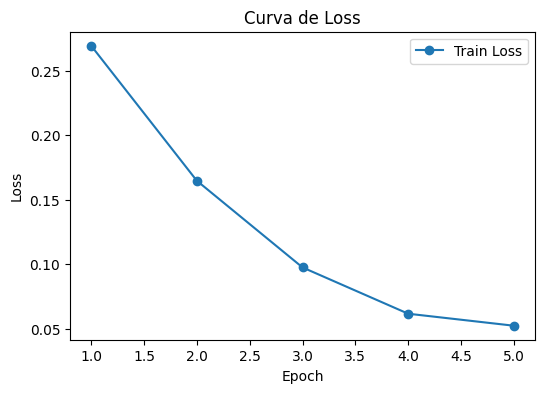

In [1]:
import matplotlib.pyplot as plt

# Loss por epoch que me diste
train_losses = [0.2693, 0.1646, 0.0974, 0.0615, 0.0522]

# Si no tienes validación separada, podemos graficar solo train
plt.figure(figsize=(6,4))
plt.plot(range(1,6), train_losses, marker='o', label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Curva de Loss")
plt.legend()
plt.show()


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 5
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(num_epochs):
    # --- Entrenamiento ---
    model.train()
    running_loss, running_corrects, total = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        preds = torch.argmax(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)
        total += labels.size(0)
    
    train_losses.append(running_loss/total)
    train_accuracies.append((running_corrects.double()/total).item())
    
    # --- Evaluación en test ---
    model.eval()
    running_loss, running_corrects, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            preds = torch.argmax(outputs,1)
            running_corrects += torch.sum(preds == labels.data)
            total += labels.size(0)
    
    test_losses.append(running_loss/total)
    test_accuracies.append((running_corrects.double()/total).item())
    
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_losses[-1]:.4f}, Acc: {train_accuracies[-1]:.4f} | "
          f"Test Loss: {test_losses[-1]:.4f}, Acc: {test_accuracies[-1]:.4f}")


NameError: name 'model' is not defined